# <center>Data Mining project: Discover and describe areas of interest<br> and events from geo-located parsed_data</center>

# 0/ Import Dataset and Libraries

## #1 Importing Libraries

- ### Installs

>requires: `pip install ipykernel`

In [ ]:

# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
# plotting 
! pip install matplotlib==3.8.0 
# Language processing
! pip install nltk
! python -m nltk.downloader popular # popular functions
# Folium
! pip install folium==0.12.1
# Geopandas
! pip install geopandas shapely 




- ###   Imports

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster as cl
import folium
from folium.plugins import MarkerCluster
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


c:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## #2 Importing Data

In [3]:
# Charger les données avec low_memory=False pour éviter les avertissements
DATA = pd.read_csv("data/flickr_data2.csv", sep=",", low_memory=False)
random.seed(42)

# I/ Understanding the Data

--Write something to describe this part of the report--

## #1 Data clearing and preparation

In [4]:
# Print details about parsing step:
# -> Number of lines parsed - % of original data parsed
def parse_conclusion(parsed_data):
    l = len(parsed_data)
    print(f"<Lines parsed: {l} - {round(100*l/len(DATA),3)}% of original data>")

- Étape 1 : Nettoyage initial des colonnes

In [5]:
# Supprimer les espaces supplémentaires dans les noms des colonnes
parsed_data = DATA
parsed_data.columns = parsed_data.columns.str.strip()

# Convertir les colonnes temporelles en numériques
# Liste des colonnes temporelles
time_columns = [
    'date_taken_minute', 'date_taken_hour', 'date_taken_day',
    'date_taken_month', 'date_taken_year',
    'date_upload_minute', 'date_upload_hour', 'date_upload_day',
    'date_upload_month', 'date_upload_year'
]

# Convertir chaque colonne en int64, remplacer les erreurs par 0
for col in time_columns:
    parsed_data[col] = pd.to_numeric(DATA[col], errors='coerce').fillna(0).astype('int64')

- Étape 2 : Suppression des doublons basés sur l'identifiant unique

In [6]:
# Sauvegarder les doublons pour audit futur
duplicate_data = parsed_data[parsed_data['id'].duplicated(keep='first')].sort_values("id")
duplicate_data.to_csv(
    "data/parsed_lines/duplicatedId.csv", index=False
)

# Supprimer les doublons
parsed_data = parsed_data[~parsed_data['id'].duplicated(keep='first')]

parse_conclusion(duplicate_data)

<Lines parsed: 252143 - 60.0% of original data>


- Étape 3 : Gestion des colonnes inutilisées ou corrompues

In [7]:
# Identifier les colonnes inutiles
unused_columns = ["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", 
                  "date_upload_minute", "date_upload_hour", "date_upload_day", 
                  "date_upload_month", "date_upload_year"]

# Sauvegarder les données corrompues
corrupted_data = parsed_data[parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull()]
corrupted_data.to_csv(
    "data/parsed_lines/corrupted_data.csv"
, index=False)


# Supprimer les colonnes inutilisées et les lignes corrompues
parsed_data = parsed_data[~(parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull())]
parsed_data = parsed_data.drop(columns=unused_columns)

parse_conclusion(corrupted_data)

<Lines parsed: 47 - 0.011% of original data>


- Étape 4 : Nettoyage des coordonnées GPS exterieures à Lyon

In [8]:
# Définir les limites géographiques de Lyon
lyon_lat_min, lyon_lat_max = 45.69, 45.85
lyon_lon_min, lyon_lon_max = 4.78, 4.92

# Sauvegarder les données not Lyonnaises ou non definies
out_lyon_data = parsed_data[
    ~((parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max))
]
out_lyon_data.to_csv(
    "data/parsed_lines/out_lyon.csv"
, index=False)

# Filtrer les données pour garder uniquement les points dans Lyon
parsed_data = parsed_data[
    (parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max)
]

parse_conclusion(out_lyon_data)

<Lines parsed: 10502 - 2.499% of original data>


- Étape 5 : Gestion des valeurs manquantes

In [9]:
# Supprimer les lignes avec des valeurs manquantes
#parsed_data = parsed_data.dropna(subset=['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute', 'date_taken_hour', 'date_taken_day', 'date_taken_month', 'date_taken_year'])

# Sauvegarder les lignes à données manquantes
val_manquante_data = parsed_data[parsed_data.drop(columns=['tags','title']).isna().any(axis = 1)]
val_manquante_data.to_csv(
    "data/parsed_lines/NaNs.csv"
, index=False)

# Remplir les valeurs manquantes pour les colonnes textuelles par des chaînes vides
parsed_data['tags'] = parsed_data['tags'].fillna('')
parsed_data['title'] = parsed_data['title'].fillna('')

parse_conclusion(val_manquante_data)

<Lines parsed: 0 - 0.0% of original data>


- Étape 6 : Filtrage des dates incohérentes

In [10]:
min_year = 2009

# Sauvegarder les données ayant des date non correcte
uncorrect_date_data = parsed_data[
    ~((parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59))
]
uncorrect_date_data.to_csv(
    "data/parsed_lines/uncorrect_date.csv"
, index=False)

# Garder uniquement les dates raisonnables (entre 2009 et 2025)
parsed_data = parsed_data[
    (parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59) 
]

parse_conclusion(uncorrect_date_data)

<Lines parsed: 2028 - 0.483% of original data>


- Étape 7 : Nettoyage/Standarisation des colonnes textuelles

In [11]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Supprimer les caractères spéciaux et passer en minuscules
    return re.sub(r'[^a-zA-Z0-9, ]', '', text).lower()

# Appliquer le nettoyage sur les colonnes textuelles
parsed_data['tags'] = parsed_data['tags'].apply(clean_text)
parsed_data['title'] = parsed_data['title'].apply(clean_text)

# Vérifier les résultats
# parsed_data.head()

- Étape 8 : Ajout de la colonne temps_diff (sec). <br><br> Correspond à la différence en secondes entre l'année 2005 pile (0s,0min,...) et la date de prise de la photo. <br>Utile pour le clustering spatio-temporel.

In [122]:
print("minimum date: " + str(parsed_data['date_taken_year'].min())) 

# Create a datetime column from the given columns
dates = pd.to_datetime(
    {
        'year': parsed_data['date_taken_year'],
        'month': parsed_data['date_taken_month'],
        'day': parsed_data['date_taken_day']
    }
) + pd.to_timedelta(parsed_data['date_taken_minute'], unit='m') + pd.to_timedelta(parsed_data['date_taken_hour'], unit='h')

# Calculate difference from 1970-01-01 in seconds
parsed_data['temps_diff'] = (dates - pd.Timestamp('2005-01-01')).dt.total_seconds()

# Vérifier les résultats
# parsed_data.head()

minimum date: 2009


- Étape 9 : Standardization.

In [123]:
from sklearn.preprocessing import StandardScaler

# Appliquer la standardisation
scaler = StandardScaler()
parsed_data[["lat_std","long_std","temps_diff"]] = scaler.fit_transform(parsed_data[["lat", "long","temps_diff"]])

# Vérifier les résultats
# parsed_data.head()

- Résultat final

In [124]:
# Résumé final des données nettoyées
print("Données nettoyées :")

# Réindexer les données
parsed_data = parsed_data.reset_index(drop=True)


# Sauvegarder les données nettoyées pour les prochaines étapes
parsed_data.to_csv("data/cleaned_flickr_data.csv", index=False)

parsed_data.head(5)

Données nettoyées :


,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,temps_diff,lat_std,long_std,cluster_DBSCAN,cluster_DBSCAN_st
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhne,chaise,rhnealpes",chaises avec vue,11,15,28,2,2010,-1.579992,-0.537487,-0.807554,-1,-1
1,4394748717,35853470@N00,45.753270,4.862953,,,51,17,28,2,2010,-1.579883,-0.594232,1.519000,-1,-1
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59365 r46 v103 b163,29,17,28,2,2010,-1.579898,-0.330337,0.594482,-1,-1
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",20100129 toiou avott lyon,15,20,28,1,2010,-1.610235,0.503871,2.146232,-1,-1
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",20100128 toiou avott lyon,10,20,28,1,2010,-1.610238,0.503871,2.146232,-1,-1


## #2 Visualize Data on map

In [ ]:
# Define the center of Lyon
lyon_lat, lyon_lon = 45.75, 4.85  # Approximate coordinates for Lyon, France

# Create a Folium map
map_lyon = folium.Map(location=[lyon_lat, lyon_lon], zoom_start=12)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(map_lyon)

# Add points from the dataset
for _, row in parsed_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],  # Replace with 'lat' and 'long' if necessary
        popup=f"Tags: {row['tags']}, Title: {row['title']}",  # Optional popup information
    ).add_to(marker_cluster)

# Display the map
map_lyon

# Optional: Save the map as an HTML file
map_lyon.save("lyon_map_unclustered.html")

## #3 Clustering data

To cluster the geo-located data from Lyon, we will apply multiple clustering techniques to identify areas of interest and patterns of activity.

Our aim is to :

- Identify dense regions of photo-taking activity, which may correspond to points of interest (e.g., landmarks, parks).
- Highlight outliers or isolated points that may not belong to any significant cluster.
- Compare different clustering techniques to determine the most effective one for this dataset.

### Setup:

In [189]:
clustered_data = parsed_data
clustered_data_st = parsed_data
clustered_data_st["temps_diff"] /= 225

features_base = ["lat", "long"]
features_spatio_temp = ["lat_std", "long_std", "temps_diff"]
features_lat_lng = ["lat_std", "long_std"]
lyon_lat, lyon_lon = 45.75, 4.85

In [197]:
def create_folium_map(clusteredData, clusterInfoColumnName, sampleSize):
    map = folium.Map([lyon_lat, lyon_lon], zoom_start = 12, scrollWheelZoom = True) 
    icon_color = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for i in range(clusteredData[clusterInfoColumnName].nunique())]
    for i,row in clusteredData.sample(sampleSize).iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=5,
            color=icon_color[int(row[clusterInfoColumnName]) - 1],
            fill_color=icon_color[int(row[clusterInfoColumnName]) - 1],
            fill=True,
            popup=
                #str(row[clusterInfoColumnName])+'\n'+ # Debug (show cluster number)
                row['title']
        ).add_to(map)

    map.save("data/Maps/"+clusterInfoColumnName+"_map.html")

### a) K-means

>Why? Suitable for finding spherical clusters in data.<br>
Input required: Number of clusters (k).<br>
Steps: Apply K-Means with varying values of k to find the optimal number of clusters using the elbow method.


- Finding K with the elbow method

k = 1 - WCSS = 311040.0000000033
k = 2 - WCSS = 193308.58304795827
k = 3 - WCSS = 92331.81699365056
k = 4 - WCSS = 72915.77657658418
k = 5 - WCSS = 54676.56567628355


/var/folders/02/pn6v6_p924397h_95y6dszsw0000gn/T/ipykernel_73239/919349804.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ks_df = pd.concat([ks_df, new_row], ignore_index=True)


k = 6 - WCSS = 45330.84961505438
k = 7 - WCSS = 41457.71398405377
k = 8 - WCSS = 31289.210982345547
k = 9 - WCSS = 27987.056336243502
k = 10 - WCSS = 25194.13156004726
k = 11 - WCSS = 22691.30183208875
k = 12 - WCSS = 22467.184989559843
k = 13 - WCSS = 20318.374571341672
k = 14 - WCSS = 19139.116054809332
k = 15 - WCSS = 18284.200626787224
k = 16 - WCSS = 15570.078093749216
k = 17 - WCSS = 14400.421083507936
k = 18 - WCSS = 13475.229597251535
k = 19 - WCSS = 12391.731748572265
k = 20 - WCSS = 12072.252506705157


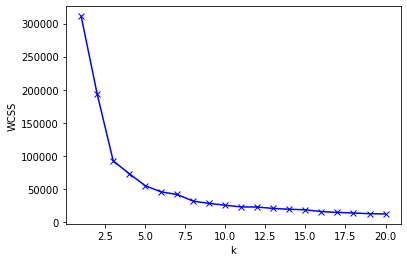

In [18]:
ks_df = pd.DataFrame(columns=["k", "WCSS"])
for k in range(1,21):
    kmeans = cl.KMeans(n_clusters=k, init='k-means++',random_state=42)
    kmeans.fit(clustered_data[features_lat_lng])
    print("k = " + str(k) + " - WCSS = " + str(kmeans.inertia_))
    new_row = pd.DataFrame({"k": [k], "WCSS": [kmeans.inertia_]})
    ks_df = pd.concat([ks_df, new_row], ignore_index=True)

plt.xlabel("k")
plt.ylabel("WCSS")
plt.plot(ks_df["k"], ks_df["WCSS"], "-xb")

We observe that the best k from the elbow method is k = 5

- Clustering data

In [19]:
# number of clusters 
k = 5 # set to optimal k found with elbow method
# create a model
kmeans = cl.KMeans(n_clusters=k, init='k-means++',random_state=42)
# fit scaled data
kmeans.fit(clustered_data[features_lat_lng])
# Add labels to data
K_mean_labels = kmeans.labels_
clustered_data = clustered_data.join(pd.DataFrame({"cluster_kmeans": K_mean_labels}))
clustered_data = clustered_data[clustered_data.cluster_kmeans != -1] # Takeout outliers

- Visualizing results

Sum of squared distances: 54676.56567628354


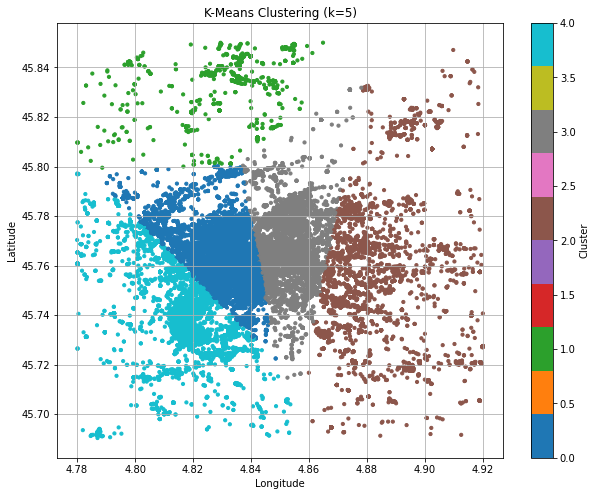

In [20]:
# Evaluate clustering
inertia = kmeans.inertia_
print(f"Sum of squared distances: {kmeans.inertia_}")

# sample_silhouette_values = silhouette_samples(clustered_data[features_base], K_mean_labels)
# means_lst = []
# for label in range(k):
#     means_lst.append(sample_silhouette_values[K_mean_labels == label].mean())

# Visualisation des clusters sur une carte simple
plt.figure(figsize=(10, 8))
plt.scatter(clustered_data['long'], clustered_data['lat'], c=clustered_data['cluster_kmeans'], cmap='tab10', s=10)
plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()


In [69]:
# Creation de la Map
create_folium_map(clustered_data, 'cluster_kmeans', 10000)

We can clearly see that the elbow method is insufficient to determine an optimal k given proximity.<br>
K means is also unoptimal given non globular clusters and proximity to each other.

### b) DBSCAN

### DBSCAN with only coordinates
- Finding Best EPS

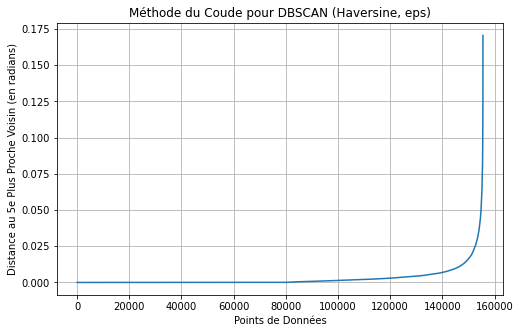

In [ ]:
# 2. Recherche du meilleur paramètre `eps` avec la méthode du coude pour les k-plus proches voisins
# Trouver les distances au k-plus proche voisin (on prend k = 5)
nbrs = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(clustered_data[features_lat_lng])
distances, indices = nbrs.kneighbors(clustered_data[features_lat_lng])

# Trier les distances pour identifier un coude
sorted_distances = np.sort(distances[:, -1])  # Distance au 5e plus proche voisin
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title("Méthode du Coude pour DBSCAN (Euclidean, eps)")
plt.xlabel("Points de Données")
plt.ylabel("Distance au 5e Plus Proche Voisin")
plt.grid()
plt.show()

La distance eps optimale est proche de 0.00005 rad. <br>
Or par l'expérimentation nous avons trouvé qu'elle est de 0.0000487.

La distance eps optimale est proche de 0.0125 rad. <br>
Or par l'expérimentation nous avons trouvé qu'elle est de 0.012175.

- Clustering Data

In [79]:
# 3. Définir un `eps` en fonction du coude observé (par exemple, eps=0.01)
# Note : eps est en radians, correspondant à une distance angulaire (~6371 km * radians pour une distance en km)

# eps = 300 / 6371000
eps = 0.004
min_samples = 45

# Appliquer DBSCAN avec la métrique Haversine
dbscan = cl.DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
dbscan_labels = dbscan.fit_predict(clustered_data[features_lat_lng]) 

In [80]:
# 4. Ajouter les étiquettes aux données
clustered_data["cluster_DBSCAN"] = dbscan_labels

# Compter le nombre de clusters (ignorer les outliers marqués comme -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_outliers = sum(dbscan_labels == -1)
clustered_data = clustered_data[clustered_data.cluster_DBSCAN != -1] # Takeout outliers

- Visualizing results

Nombre de clusters détectés : 335
Nombre d'outliers : 79532


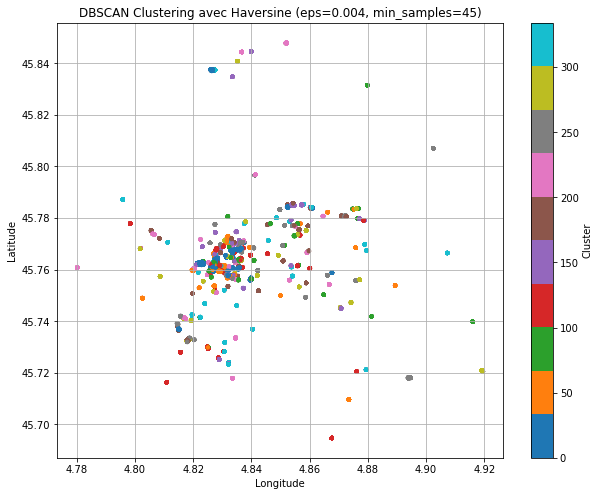

In [81]:
# 5. Visualisation des clusters
print(f"Nombre de clusters détectés : {num_clusters}")
print(f"Nombre d'outliers : {num_outliers}")

plt.figure(figsize=(10, 8))
plt.scatter(
    clustered_data['long'], 
    clustered_data['lat'], 
    c=clustered_data['cluster_DBSCAN'], 
    cmap='tab10', 
    s=10
)
plt.title(f"DBSCAN Clustering avec Haversine (eps={eps}, min_samples={min_samples})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

create_folium_map(clustered_data, 'cluster_DBSCAN', 30000)


### DBSCAN with coordinates and time
- Finding Best EPS

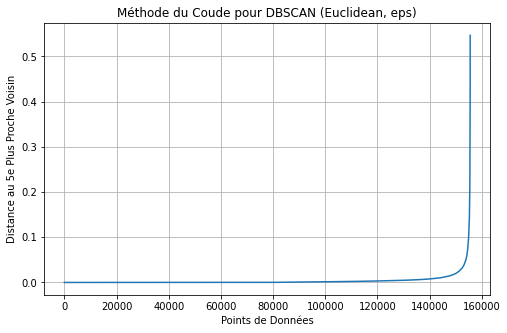

In [181]:
# 2. Recherche du meilleur paramètre `eps` avec la méthode du coude pour les k-plus proches voisins
# Trouver les distances au k-plus proche voisin (on prend k = 5)
nbrs = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(clustered_data_st[features_spatio_temp])
distances, indices = nbrs.kneighbors(clustered_data_st[features_spatio_temp])

# Trier les distances pour identifier un coude
sorted_distances = np.sort(distances[:, -1])  # Distance au 5e plus proche voisin
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title("Méthode du Coude pour DBSCAN (Euclidean, eps)")
plt.xlabel("Points de Données")
plt.ylabel("Distance au 5e Plus Proche Voisin")
plt.grid()
plt.show()

- Clustering Data

In [193]:
# 3. Définir un `eps` en fonction du coude observé (par exemple, eps=0.01)
# Note : eps est en radians, correspondant à une distance angulaire (~6371 km * radians pour une distance en km)

# eps = 300 / 6371000
eps = 0.004
min_samples = 45

# Appliquer DBSCAN avec la métrique Euclidean
dbscan_st = cl.DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
dbscan_labels_st = dbscan_st.fit_predict(clustered_data_st[features_spatio_temp]) 

In [194]:
# 4. Ajouter les étiquettes aux données
clustered_data_st["cluster_DBSCAN_st"] = dbscan_labels_st

# Compter le nombre de clusters (ignorer les outliers marqués comme -1)
num_clusters = len(set(dbscan_labels_st)) - (1 if -1 in dbscan_labels_st else 0)
num_outliers = sum(dbscan_labels_st == -1)
clustered_st = clustered_data_st[clustered_data_st.cluster_DBSCAN_st != -1] # Takeout outliers

- Visualizing results

Nombre de clusters détectés : 335
Nombre d'outliers : 79532


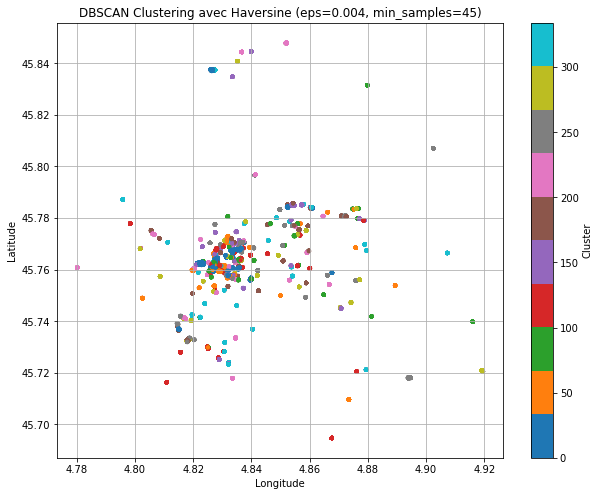

In [198]:
# 5. Visualisation des clusters
print(f"Nombre de clusters détectés : {num_clusters}")
print(f"Nombre d'outliers : {num_outliers}")

plt.figure(figsize=(10, 8))
plt.scatter(
    clustered_st['long'], 
    clustered_st['lat'], 
    c=clustered_st['cluster_DBSCAN_st'], 
    cmap='tab10', 
    s=10
)
plt.title(f"DBSCAN Clustering avec Haversine (eps={eps}, min_samples={min_samples})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

create_folium_map(clustered_st, 'cluster_DBSCAN_st', 30000)


### c) Hierarchical Clustering

>Why? Provides a dendrogram to visualize the hierarchy of clusters.<br>
Input required: No predefined number of clusters; can be adjusted by cutting the dendrogram.<br>
Steps: Compute a linkage matrix using ward or other linkage methods. Cut the dendrogram to form clusters.

In [1]:
# 1. Préparation des données
# Sous-échantillonnage des données (garder n points aléatoires pour éviter les blocages)

geo_data_sampled = parsed_data.sample(n=10000, random_state=42)
geo_data_sampled.reset_index(drop=True)

# 2. Création de la matrice de linkage avec les données échantillonnées
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(geo_data_sampled[features_base], method='ward')

# 3. Visualisation du dendrogramme
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate pour simplifier la visualisation
plt.title("Dendrogramme (Clustering Hiérarchique - Échantillonné)")
plt.xlabel("Points de données")
plt.ylabel("Distance")
plt.show()

# 4. Découpage du dendrogramme pour obtenir les clusters
num_clusters = 188  # Nombre de clusters à obtenir
sampled_clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Ajouter les clusters à l'échantillon pour analyse
geo_data_sampled['hierarchical_cluster'] = sampled_clusters

NameError: name 'parsed_data' is not defined

- Visualizing results

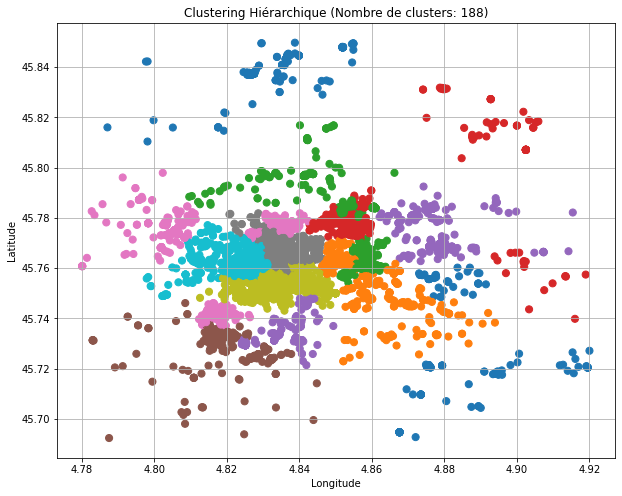

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(geo_data_sampled['long'], geo_data_sampled['lat'], c=geo_data_sampled['hierarchical_cluster'], cmap='tab10', s=50)
plt.title(f"Clustering Hiérarchique (Nombre de clusters: {num_clusters})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()
create_folium_map(geo_data_sampled, 'hierarchical_cluster', 10000)

## #4 post-processing

In [ ]:
post_processed_data = clustered_data
post_processed_data.head(1)

,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,temps_diff,lat_std,long_std,cluster_kmeans,cluster_DBSCAN
9,4392367159,47924539@N05,45.762059,4.822654,"france,lyon,fourvire,lesphotosdevoyage",fourvire,28,12,27,2,2010,-1.581085,-0.280167,-0.754302,0,4


### Filter groups where there isn't enough users: low number of samples or very few users withing the cluster.

In [ ]:
user_limit = 5
for cluster_i in range(post_processed_data["cluster_DBSCAN"].nunique()):
    cluster = post_processed_data[post_processed_data.cluster_DBSCAN == cluster_i]
    nbUsers = cluster["user"].nunique()
    if(nbUsers < user_limit):
        cluster.to_csv(
            "data/post_processing/insufficient_users_clusters/"+str(cluster_i)+".csv",
        index=False)
        post_processed_data = post_processed_data[~post_processed_data["id"].isin(cluster["id"])]
parse_conclusion(post_processed_data)

<Lines parsed: 56442 - 13.431% of original data>


## #5 Description of areas of interest using text pattern mining

In [ ]:
# Télécharger les ressources de NLTK
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Charger les stopwords en français et en anglais
stop_words = set(stopwords.words('french') + stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text):
    """
    Nettoyer un texte :
    - Conversion en minuscules
    - Suppression des caractères spéciaux
    - Tokenisation
    - Suppression des stopwords
    - Suppression des identifiants alphanumériques (ex: ddc4674)
    - Lemmatisation
    - Suppression des espaces inutiles
    """
    text = str(text).lower()  # Convertir en minuscules
    text = re.sub(r'\b[a-zA-Z]{2,4}\d+\b', '', text)  # Supprimer les identifiants alphanumériques (ex: "ddc4674")
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Supprimer les caractères spéciaux mais garder les espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces en double et au début/fin
    words = word_tokenize(text)  # Tokenisation
    words = [word for word in words if word not in stop_words]  # Suppression des stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation
    return " ".join(words)


In [ ]:
# Nettoyage des titres et des tags
post_processed_data["title_clean"] = post_processed_data["title"].fillna("").apply(clean_text)
post_processed_data["tags_clean"] = post_processed_data["tags"].fillna("").apply(lambda x: clean_text(x.replace(",", " ")))


In [ ]:
# Ajouter une colonne combinée pour l'analyse
post_processed_data["text_clean"] = post_processed_data["title_clean"] + " " + post_processed_data["tags_clean"]

In [ ]:
# Associer les Clusters aux Textes
# D'abord, il faut fusionner les clusters DBSCAN (clustered_data) avec les titres et tags nettoyés (post_processed_data).

# Fusion sur la colonne "id"
df_clusters_texts = clustered_data.merge(post_processed_data, on="id", how="inner")

# Renommer les colonnes pour éviter les doublons (cluster_DBSCAN_x et cluster_DBSCAN_y puisque
df_clusters_texts.rename(columns={"cluster_DBSCAN_x": "cluster_DBSCAN"}, inplace=True)
# Supprimer les colonnes inutiles (doublons)
df_clusters_texts.drop(columns=["cluster_DBSCAN_y"], errors="ignore", inplace=True)


In [ ]:
# On enregistre cluster_DBSCAN, lat, long, id et text_clean dans un CSV pour plus tard
# Sélectionner uniquement les colonnes nécessaires
df_clusters_texts = post_processed_data[['id', 'lat', 'long', 'cluster_DBSCAN', 'text_clean']]

# Sauvegarder sous CSV pour l'application
df_clusters_texts.to_csv("df_clusters_texts.csv", index=False)

# Vérifier le fichier créé
df_check = pd.read_csv("df_clusters_texts.csv")
print(df_check.head())  # Vérifie que les colonnes sont bien présentes
print(df_check.columns)  # Vérifie les noms de colonnes
print(df_check.isnull().sum())  # Vérifie s'il y a des valeurs manquantes

print("✅ Fichier df_clusters_texts.csv créé avec succès !")


           id        lat      long  cluster_DBSCAN  \
0  4392367159  45.762059  4.822654               4   
1  4393122952  45.767328  4.833362               6   
2  4391929257  45.837545  4.826130               0   
3  4391929181  45.837545  4.826130               0   
4  4391929097  45.837545  4.826130               0   

                                          text_clean  
0    fourvire france lyon fourvire lesphotosdevoyage  
1                    lyon novembre lesphotosdevoyage  
2  vulcain monde felix portrait sculpture streeta...  
3  vulcain monde felix portrait sculpture streeta...  
4  vulcain monde felix portrait sculpture streeta...  
Index(['id', 'lat', 'long', 'cluster_DBSCAN', 'text_clean'], dtype='object')
id                0
lat               0
long              0
cluster_DBSCAN    0
text_clean        0
dtype: int64
✅ Fichier df_clusters_texts.csv créé avec succès !


In [ ]:
#ANALYSE DE LA FREQUENCE DES MOTS DANS CHAQUE CLUSTER

# Regrouper les textes de chaque cluster en une seule grande string
cluster_texts = df_clusters_texts.groupby("cluster_DBSCAN")["text_clean"].apply(lambda x: " ".join(x))

print(cluster_texts.head(5))

cluster_DBSCAN
0    vulcain monde felix portrait sculpture streeta...
1    passerelle rendezvous bridge lyon rhne pont so...
2    square lamp lamp dailypicture leffe beer glass...
4    fourvire france lyon fourvire lesphotosdevoyag...
5     lyon liquid lyon  lyon  lyon banana lyon scar...
Name: text_clean, dtype: object


**On continue le filtrage pour faire des analyses cohérentes par la suite.**

On exclut de nombreux mots non significatifs de l'analyse : 

In [ ]:
from collections import Counter

# Étape 1 : Définir les mots à exclure
excluded_words = {
    # Lieux généraux et géographie trop large
    "lyon", "france", "europe", "rhne", "rhnealpes", "auvergnerhnealpes", "francia", "frankrijk", "frankreich",
      "place", "urban", "ville", "quartier", "rgionlyonnaise",
    
    # Mots trop fréquents et génériques
    "fr", "lione", "ville", "city", "urban", "travel",
    "photo", "photography", "flickr", "uploadedbyflickrmobile", "flickriosappfilternofilter",
    "onlylyon", "igerslyon", "followme", "instagood", "common", "old", "new", "people",
    "day", "summer", "night", "year", "time", "december", "open", "closed", "march", "feu","french", "juillet", "juin",
    
    # Mots de fêtes et événements
    "fte", "biennale", "biennaledelyon",
    "dec", "dcembre", "thdecember", "nuit", "illumination",
    
    # Technique photo et réseaux sociaux
    "mm", "f", "b", "p", "e", "dsc", "uploadedbyinstagram", "instagramapp", "square", "squareformat",
    "iphoneography", "jpg", "img", "picture", "foursquarevenue", "upload", "dc", "ec", "rise",
    "hudson", "xproii", "perpetua", "clarendon", "filter", "macro", "lens", "focale", "zoom", "bokeh", "flash",
    "blackandwhite", "noiretblanc", "bw", "bnw", "monochrome", "creativecommons",
    
    # Matériel photo
    "eos", "tamronsp", "canon", "nikon", "fujifilmxt", "mmf", "sonyalpha", "ilce", "dmkii", "dailypicture",
    "sigma", "leica", "summicronr", "summicron", "leitz", "nikkor", "creative", "photomobile",
    
    # Politique et manifestations
    "manifestation", "retraites", "rforme", "partidegauche", "frontdegauche", "ermai",
    "giletsjaunes", "protest", "demonstration", "justice", "palaisdejustice",
    
    # Transports
    "funiculaire", "metro", "transport", "bus", "station", "railway",
    
    
    # Noms propres peu informatifs
    "fb", "bf", "aa", "fe", "os", "bij", "ea", "fde", "ecb", "bca", "abf", "fbfeac", "visiosfeir",
    "arnalphotography", "arnallephotography", "arnaudbouvard", "capturedalive", "jaredleto",
    "shannonleto", "metallica", "martingore", "davegahan", "touroftheuniverse", "dmtotu",
    
    # Éléments spécifiques mais non significatifs
    "citt", "citta", "feste", "festa", "delle", "evento", "thtf", "adelsa", "summicronr",
    "installation", "graff", "tag", "sticker", "zombie", "walk", "revolution", "graffs",
    
    # Autres termes techniques et hashtags
    "instapic", "instagram", "igers", "pic", "like", "follow", "igersart", "paris", "wwwmonsieurbidulenet",
    "cest", "wwwsylvainmestrecom", "photographie", "black", "white", "photographe",
    
    # Abréviations et termes courts non significatifs
    "cc", "gr", "wp", "pro", "db", "ov", "dxopl", "ae", "th", "st", "bnw", "bw", "nb", "dscn", 
    "fp", "igp", "lfl", "ubb", "lou", "er", "rf", "ptdo", "fdl", "sx", "xphotographer", "bnw", 
    "wm", "cnv", "bda", "mearrondissement", "earrondissement", "lyonpresqule", "oneshot", "lyj", 
    "lyr", "accréditation", "leeloo", "capphi", "heho", "mateo", "pelussin", "jossarisfoto", 
    "panasoniclumixdmcfz", "thierryhermann", "ddc",
}




# Étape 2 : Fonction pour compter les mots qui reviennent le plus
def count_filtered_words(text):
    words = text.split()
    words = [word for word in words if word not in excluded_words]  # Filtrer
    return Counter(words)

# Étape 3 : Appliquer sur chaque cluster
filtered_word_counts_per_cluster = cluster_texts.apply(count_filtered_words)

# Étape 4 : Afficher les 10 mots les plus fréquents par cluster
for cluster, word_counts in filtered_word_counts_per_cluster.items():
    print(f"🔹 Cluster {cluster} - Top 10 mots :")
    print(word_counts.most_common(10))  # Top 10 mots du cluster
    print("-" * 50)  # Ligne de séparation


🔹 Cluster 0 - Top 10 mots :
[('chaos', 15157), ('demeureduchaos', 12634), ('abodeofchaos', 12542), ('thierryehrmann', 12263), ('alchemy', 11983), ('portrait', 11933), ('prophecy', 11711), ('contemporaryart', 11687), ('secret', 11622), ('organmuseum', 11606)]
--------------------------------------------------
🔹 Cluster 1 - Top 10 mots :
[('hteldieu', 7), ('bergesdurhne', 6), ('january', 5), ('iphone', 5), ('carolechevallet', 5), ('cacolebn', 5), ('hipstamatic', 5), ('quaisdurhne', 5), ('water', 4), ('ktm', 4)]
--------------------------------------------------
🔹 Cluster 2 - Top 10 mots :
[('vieux', 6), ('duck', 5), ('bird', 4), ('apartment', 4), ('lamp', 2), ('leffe', 2), ('beer', 2), ('barman', 2), ('portrait', 2), ('akroche', 2)]
--------------------------------------------------
🔹 Cluster 4 - Top 10 mots :
[('fourvire', 2326), ('basilique', 1451), ('basilica', 759), ('fourviere', 718), ('notredame', 716), ('church', 583), ('dame', 573), ('frana', 272), ('architecture', 271), ('panora

**On applique maintenant TF-IDF sur les clusters filtrés**
TF-IDF réduit l'importance des mots fréquents dans plusieurs clusters et met en valeur ceux qui sont plus spécifiques à certains clusters.

In [ ]:
# 🔹 Étape 1 : Transformer les données pour TF-IDF
cluster_texts_filtered = {cluster: " ".join(words.elements()) for cluster, words in filtered_word_counts_per_cluster.items()}

# 🔹 Étape 2 : Appliquer TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cluster_texts_filtered.values())

# 🔹 Étape 3 : Récupérer les mots et scores
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=cluster_texts_filtered.keys(), columns=feature_names)

# 🔹 Étape 4 : Stocker tous les mots avec leurs scores pour chaque cluster
top_keywords_per_cluster = {
    cluster: list(zip(df_tfidf.loc[cluster].index, df_tfidf.loc[cluster].values))  # Stocker tous les mots
    for cluster in df_tfidf.index
}

# 🔹 Étape 5 : Affichage des 10 mots les plus pertinents par cluster
for cluster, keywords in top_keywords_per_cluster.items():
    top_10 = sorted(keywords, key=lambda x: x[1], reverse=True)[:10]  # Trier et récupérer top 10
    print(f"\n🔹 Cluster {cluster} - TOP 10 Mots-clés TF-IDF avec scores :")
    for word, score in top_10:
        print(f"   - {word}: {score:.4f}")  # Affichage avec 4 décimales
    print("-" * 50)

# 🔹 Étape 6 : Stocker tous les résultats sous forme de dataframe pour réutilisation
df_tfidf_long = df_tfidf.stack().reset_index()
df_tfidf_long.columns = ['Cluster', 'Word', 'TF-IDF Score']

# 🔹 Sauvegarde des résultats en CSV pour une réutilisation plus tard
df_tfidf_long.to_csv("tfidf_results.csv", index=False)





🔹 Cluster 0 - TOP 10 Mots-clés TF-IDF avec scores :
   - chaos: 0.2206
   - demeureduchaos: 0.1839
   - abodeofchaos: 0.1825
   - thierryehrmann: 0.1785
   - alchemy: 0.1744
   - prophecy: 0.1705
   - organmuseum: 0.1689
   - mystery: 0.1685
   - lespritdelasalamandre: 0.1659
   - salamanderspirit: 0.1651
--------------------------------------------------

🔹 Cluster 1 - TOP 10 Mots-clés TF-IDF avec scores :
   - hteldieu: 0.3289
   - bergesdurhne: 0.2581
   - cacolebn: 0.2349
   - carolechevallet: 0.2349
   - quaisdurhne: 0.2240
   - ktm: 0.2151
   - yti: 0.2151
   - ambassador: 0.1992
   - duke: 0.1992
   - laguillotire: 0.1992
--------------------------------------------------

🔹 Cluster 2 - TOP 10 Mots-clés TF-IDF avec scores :
   - duck: 0.3669
   - apartment: 0.3459
   - vieux: 0.2335
   - akroche: 0.2075
   - barman: 0.2075
   - burst: 0.2075
   - rum: 0.2075
   - bird: 0.2010
   - leffe: 0.1922
   - woup: 0.1729
--------------------------------------------------

🔹 Cluster 4 - 

**On peut maintenant identifier des zones d'intérêts dans les clusters :**

🔹 Cluster 0 : Chaos, Art Contemporain et Thierry Ehrmann

🔹 Cluster 1 : Fête des Lumières et Berges du Rhône

🔹 Cluster 2 : Vieux Lyon et Ambiance de Bar

🔹 Cluster 4 : Fourvière et Architecture Religieuse

🔹 Cluster 5 : Vieux Lyon et Boutique/Rue Saint-Jean

🔹 Cluster 6 : Place des Terreaux et Beaux-Arts

🔹 Cluster 7 : Musées Gadagne et Marionnettes

🔹 Cluster 8 : Vieux Lyon et Tourisme

🔹 Cluster 9 : Place Bellecour et Grande Roue

🔹 Cluster 10 : Opéra de Lyon et Architecture

🔹 Cluster 11 : Manifestations Place Bellecour

🔹 Cluster 12 : Place du Change et Architecture Historique

🔹 Cluster 13 : Cathédrale Saint-Jean et Patrimoine Religieux

🔹 Cluster 14 : Traboules et Rues du Vieux Lyon

🔹 Cluster 15 : Théâtre des Célestins et Événements Culturels

🔹 Cluster 16 : Place des Jacobins et Fontaine

🔹 Cluster 17 : Place de la République et Fête des Lumières

🔹 Cluster 18 : Fourvière et Paysages

🔹 Cluster 19 : Photographie Urbaine et Portraits

🔹 Cluster 20 : Passerelle et Ponts de Lyon

🔹 Cluster 21 : Feux d’Artifice et Bord de Saône

🔹 Cluster 22 : Street Art et Croix-Rousse

🔹 Cluster 24 : BMX et Skatepark

🔹 Cluster 25 : Marché de Noël et Lumières de Noël

🔹 Cluster 26 : Fête des Lumières et Grand Lyon

🔹 Cluster 27 : Gare Saint-Paul et Transports

🔹 Cluster 29 : Cinéma et Musée du Cinéma

🔹 Cluster 30 : Musée Miniature et Cinéma

🔹 Cluster 31 : La Sucrière et Expositions d’Art

🔹 Cluster 32 : Musée d’Art Contemporain (MAC Lyon)

🔹 Cluster 33 : Église Saint-Nizier et Patrimoine Religieux

🔹 Cluster 34 : Funiculaire et Basilique de Fourvière

🔹 Cluster 35 : Sculptures et Lumières

🔹 Cluster 36 : Hôtel de Ville et Place des Terreaux

🔹 Cluster 37 : Passerelle et Palais de Justice

🔹 Cluster 38 : Saône et Vieux Lyon

🔹 Cluster 39 : Pont Bonaparte et Rivières

🔹 Cluster 41 : Ponts et Rhône

🔹 Cluster 42 : Église Saint-Nizier et Festival des Lumières

🔹 Cluster 43 : Théâtres Antiques de Fourvière et Nuits de Fourvière

🔹 Cluster 44 : Street Art et Croix-Rousse

🔹 Cluster 45 : Vieux Lyon et Architecture Ancienne

🔹 Cluster 46 : Basilique Saint-Martin d’Ainay et Art Roman

🔹 Cluster 47 : Faune Aquatique et Poissons

🔹 Cluster 48 : Gare Saint-Paul et Fête des Lumières

🔹 Cluster 50 : Parc de la Tête d'Or et Zoo

🔹 Cluster 51 : Collages et Street Art à Croix-Rousse

🔹 Cluster 55 : Concerts et Halle Tony Garnier

🔹 Cluster 56 : Trains et SNCF (Rotonde de Vénissieux)

🔹 Cluster 57 : Street Art et Lutra Lutra

🔹 Cluster 58 : Musiciens et Performances de Rue

🔹 Cluster 59 : Parc de la Tête d'Or et Nature

🔹 Cluster 60 : Cathédrale Saint-Jean et Photographie

🔹 Cluster 62 : Zombiewalk et Événements Urbains

🔹 Cluster 63 : Paysages et Ponts de Lyon

🔹 Cluster 64 : Place Antonin Poncet et Unesco

🔹 Cluster 65 : Passerelle et Saxophones

🔹 Cluster 66 : Musée des Beaux-Arts de Lyon et Patrimoine

🔹 Cluster 67 : Street Art et Pasteups

🔹 Cluster 68 : Street Art et Papier Collé

🔹 Cluster 69 : Fourvière et Feux d’Artifice

🔹 Cluster 71 : Musée des Confluences et Expositions

🔹 Cluster 73 : Parc de la Tête d’Or et Lumières

🔹 Cluster 74 : Vieux Lyon et Boutiques Artisanales

🔹 Cluster 75 : Basilique de Fourvière et Expositions

🔹 Cluster 76 : Concerts et Nuits Sonores

🔹 Cluster 77 : Fourvière et Vue Panoramique

🔹 Cluster 79 : Confluence et Urbanisme Moderne

🔹 Cluster 82 : Palais de la Bourse et Architecture

🔹 Cluster 83 : Traboules et Vieille Ville

🔹 Cluster 88 : Fanfare et Musique de Rue

🔹 Cluster 89 : Stade de Gerland et Rugby

🔹 Cluster 94 : Pont Lafayette et Paysages Urbains

🔹 Cluster 95 : Place Antonin Poncet et Fontaine

🔹 Cluster 98 : Montée du Gourguillon et Vieux Lyon

🔹 Cluster 99 : Bars Rock et Concerts

🔹 Cluster 100 : Musée des Beaux-Arts et Sarcophages

🔹 Cluster 101 : Charlie Hebdo et Manifestations

🔹 Cluster 102 : Concerts et Rock

🔹 Cluster 103 : Musée des Beaux-Arts et Nuits de Lyon

🔹 Cluster 104 : Parc de la Tête d’Or et Jardin Botanique

🔹 Cluster 105 : Place Bellecour et Pluie

🔹 Cluster 106 : Défilé et Danse

🔹 Cluster 108 : Fresques Lyonnaises et Mur Peint

🔹 Cluster 109 : Carnaval et Fêtes de Rue

🔹 Cluster 111 : Passerelle Saint-Vincent et Ponts de Lyon

🔹 Cluster 112 : Saône et Festival des Lumières

🔹 Cluster 115 : Passerelle du Collège et Photographie Urbaine

🔹 Cluster 116 : Supercross et Sports Extrêmes

🔹 Cluster 117 : Église Saint-Georges et Paysages Urbains

🔹 Cluster 118 : Fourvière et Lumières sur la Saône

🔹 Cluster 119 : Palais de Justice et Ponts de Lyon

🔹 Cluster 121 : Gare Part-Dieu et Transports

🔹 Cluster 122 : Nuits Sonores et Musique Électronique

🔹 Cluster 123 : Fête des Lumières et Montée de la Croix-Rousse

🔹 Cluster 124 : BMX et Shows de Rue

🔹 Cluster 125 : Traboules et Architecture

🔹 Cluster 126 : Place Sathonay et Lumières

🔹 Cluster 129 : Cactus et Serres du Parc

🔹 Cluster 131 : Rugby et Stade de Gerland

🔹 Cluster 132 : Centre Commercial Part-Dieu

🔹 Cluster 134 : Parc de la Tête d’Or et Nature

🔹 Cluster 136 : Grande Roue et Place Bellecour

🔹 Cluster 142 : Centre des Congrès et Lumières

🔹 Cluster 143 : Célébrations et Oeufs de Lumière

🔹 Cluster 144 : Place Bellecour et Manifestations

🔹 Cluster 146 : Tour Part-Dieu (Le Crayon) et Skyline de Lyon

🔹 Cluster 147 : Galeries d’Art et Expositions

🔹 Cluster 148 : Graffiti et Art Urbain

🔹 Cluster 149 : Institut Lumière et Histoire du Cinéma

🔹 Cluster 150 : Hôtel de Ville et Place des Terreaux

🔹 Cluster 151 : Basilique de Fourvière et Panorama

🔹 Cluster 155 : Négociants et Architecture Historique

🔹 Cluster 159 : Paysages Urbains et Levers de Soleil

🔹 Cluster 161 : Gare Saint-Paul et Fête des Lumières

🔹 Cluster 165 : Église des Cordeliers et Vitraux

🔹 Cluster 166 : Confluence et Cube Orange

🔹 Cluster 167 : Piscine Tony Bertrand et Sports Nautiques

🔹 Cluster 170 : Hockey sur Glace et Patinoire Charlemagne

🔹 Cluster 171 : Jardin Botanique et Parc de la Tête d’Or

🔹 Cluster 174 : Vieux Lyon et Musée Miniature

🔹 Cluster 175 : Parcs, Lacs et Nature

🔹 Cluster 176 : Expositions d’Art Contemporain

🔹 Cluster 177 : Lumières et Photographie Nocturne

🔹 Cluster 178 : Biennale de Lyon et Expositions d’Art

🔹 Cluster 182 : Saône et Paysages Fluviaux

🔹 Cluster 183 : Le Transbordeur et Concerts de Rock

🔹 Cluster 184 : Tour Part-Dieu et Architecture Moderne

🔹 Cluster 185 : Confluence et Rivières Rhône-Saône

🔹 Cluster 186 : Théâtre des Célestins et Architecture Classique

🔹 Cluster 188 : Street Art et Pochoirs Croix-Rousse

🔹 Cluster 189 : Musée des Confluences et Expositions

🔹 Cluster 191 : Gare des Brotteaux et Architecture Art Nouveau

🔹 Cluster 192 : Statues Vivantes et Performances de Rue

🔹 Cluster 193 : Zoologie et Oiseaux au Parc de la Tête d’Or

🔹 Cluster 194 : Patrimoine et UNESCO (Quartier Saint-Jean)

🔹 Cluster 195 : Marché de Noël et Perrache

🔹 Cluster 197 : Convention de Jeux et Événements Nerds (Octogônes)

🔹 Cluster 198 : Manifestations Place Bellecour

🔹 Cluster 201 : Tour Incity et Skyline Lyonnaise

🔹 Cluster 203 : Rues Commerçantes et Shopping à Lyon

🔹 Cluster 205 : Pelicans et Faune du Parc de la Tête d’Or

🔹 Cluster 208 : Congrès et Bibliothèques (IFLA, EBLIDA)

🔹 Cluster 209 : Musée Gallo-Romain et Lugdunum

🔹 Cluster 210 : Théâtre Romain et Histoire Antique

🔹 Cluster 211 : Palais de Justice et Quais de la Saône

🔹 Cluster 215 : Montée de Chazeaux et Architecture du Vieux Lyon

🔹 Cluster 221 : Nature Morte et Photographie Artistique

🔹 Cluster 222 : Fête des Lumières et Place Antonin Poncet

🔹 Cluster 223 : Lego, Jouets et Maquettes à Confluence

🔹 Cluster 225 : Cube Orange et Design Architectural

🔹 Cluster 227 : Musée Gallo-Romain et Escaliers Historiques

🔹 Cluster 230 : Lumières et Reflets sur la Saône

🔹 Cluster 231 : LDoll Festival et Poupées Articulées

🔹 Cluster 232 : Macrophotographie et Nature

🔹 Cluster 239 : Photographie Nocturne et Ponts de Confluence

🔹 Cluster 242 : Skateboard et Graffiti

🔹 Cluster 243 : Paul Bocuse et Gastronomie Lyonnaise

🔹 Cluster 245 : Confluence et Urbanisme

🔹 Cluster 246 : Macrophotographie et Gouttes d’Eau

🔹 Cluster 248 : Lumières et Ambiance Nocturne

🔹 Cluster 249 : Street Art et Superpositions Visuelles

🔹 Cluster 250 : Cube Orange et Architecture Innovante

🔹 Cluster 253 : Danse Mexicaine et UNESCO

🔹 Cluster 255 : Vieux Lyon et Hiver

🔹 Cluster 256 : Pont Raymond Barre et Confluence

🔹 Cluster 260 : Euronews et Architecture Moderne

🔹 Cluster 261 : Institut Lumière et Histoire du Cinéma

🔹 Cluster 263 : Dolls et Convention ArtDoll

🔹 Cluster 265 : Burgers et Gastronomie Lyonnaise

🔹 Cluster 266 : Canards et Faune du Parc de la Tête d’Or

🔹 Cluster 269 : Quais de Confluence et Photographie

🔹 Cluster 272 : Traboules et Rues du Vieux Lyon

🔹 Cluster 274 : Art Contemporain et Expositions

🔹 Cluster 279 : Vieux Lyon et Guignol

🔹 Cluster 280 : Berges de la Saône et Paysages Urbains

🔹 Cluster 285 : Hôtel de Région et Événements Expositions

🔹 Cluster 295 : Judo et Sports à Gerland

🔹 Cluster 300 : Parc de la Tête d’Or et Fleurs

🔹 Cluster 308 : Digital Summit et Innovation

🔹 Cluster 309 : Jeux de Lumières et Scènes Urbaines

🔹 Cluster 313 : Passerelle du Palais de Justice et Lyon de Nuit

🔹 Cluster 318 : Lumières et Photographie Artistique

🔹 Cluster 320 : Tour Rose et Traboules du Vieux Lyon

🔹 Cluster 323 : Villeurbanne et Arts de la Rue

**On va maintenant appliquer FP-Growth pour détecter les associations de mots.**

On utilise FP-Growth et pas à-priori car le dataset est trop grand

L'algorithme FP-Growth est généralement plus rapide et efficace qu'Apriori, surtout avec un grand nombre de mots (+3 000 000). 

Nous utiliserons FP-Growth pour extraire les associations entre les mots-clés des clusters.

📌 Paramètres optimaux

1️⃣ min_support (Support minimal)

Détermine la fréquence minimale d'un ensemble de mots dans les clusters.

Choix : Pour +5 000 000 de mots, on commence avec 0.01 (1%) et on ajuste si besoin.

0.05 (5%) : Associations très fréquentes, mais risque d'ignorer des associations intéressantes.

0.005 (0.5%) : Capture plus de relations, mais peut générer trop de règles non pertinentes.


2️⃣ min_threshold (Seuil de confiance)

Détermine la probabilité conditionnelle d'apparition d'un mot sachant qu'un autre est présent.

Choix : 0.5 (50%) → Si A est présent, il y a 50% de chances que B soit aussi présent.

0.7 (70%) : Plus restrictif, mais meilleur pour identifier les liens forts.

0.3 (30%) : Plus permissif, mais peut capturer trop de bruit.



In [ ]:
# 🔹 Étape 1 : Construire les transactions (10 mots les plus pertinents par cluster)
transactions = [ [word for word, score in sorted(top_keywords_per_cluster[cluster], key=lambda x: x[1], reverse=True)[:10]] 
                 for cluster in top_keywords_per_cluster ]

# 🔹 Étape 2 : Encoder les transactions pour FP-Growth
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# 🔹 Étape 3 : Appliquer FP-Growth avec un support initial de 3% (réglable)
frequent_itemsets = fpgrowth(df_encoded, min_support=0.03, use_colnames=True)


# 🔹 Étape 4 : Extraire les règles d'association avec une confiance minimale de 50%
rules = association_rules(frequent_itemsets, num_itemsets=len(top_keywords_per_cluster), metric="confidence", min_threshold=0.95)

# 🔹 Étape 5 : Trier les règles par lift (pertinence)
rules = rules.sort_values(by="lift", ascending=False)

# 🔹 Étape 7 : Sauvegarde des résultats pour analyse ultérieure
rules.to_csv("association_rules.csv", index=False)
print("\nRègles d'association sauvegardées sous 'association_rules.csv'")



Règles d'association sauvegardées sous 'association_rules.csv'


**On va maintenant générer une nouvelle map pour afficher les textes liés et associés à chaque cluster.**

In [ ]:
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
import random
import matplotlib.colors as mcolors
import ast

# Charger les données
df_clusters = pd.read_csv("df_clusters_texts.csv")
df_tfidf = pd.read_csv("tfidf_results.csv")
df_associations = pd.read_csv("association_rules.csv")

# 🛠️ Vérifier les coordonnées anormales
df_clusters = df_clusters[(df_clusters["lat"].between(45.5, 45.9)) & (df_clusters["long"].between(4.7, 4.9))]

# Correction du type de la colonne Cluster
df_tfidf["Cluster"] = df_tfidf["Cluster"].astype(int)

# Fonction pour récupérer les mots-clés avec TF-IDF > 0.05
def get_top_tfidf_texts(cluster_id, threshold=0.05):
    words = df_tfidf[(df_tfidf["Cluster"] == cluster_id) & (df_tfidf["TF-IDF Score"] > threshold)]["Word"].tolist()
    return words if words else ["Aucun mot important trouvé"]

# Fonction pour récupérer les associations liées aux mots TF-IDF > 0.05
def get_associated_words(cluster_id, tfidf_words):
    """Trouve les associations où au moins un mot TF-IDF est un antécédent."""
    associated_words = set()

    for _, row in df_associations.iterrows():
        try:
            antecedents = eval(row["antecedents"])  # Convertir en set de mots
            consequents = eval(row["consequents"])

            # Vérifier si AU MOINS UN mot TF-IDF du cluster est un antécédent
            if any(word in antecedents for word in tfidf_words):
                associated_words.update(consequents)  # Ajouter les conséquents associés

        except Exception as e:
            print(f"Erreur parsing association: {e}")  # Debugging si erreur parsing

    return list(associated_words) if associated_words else ["Aucune association trouvée"]


# Créer un GeoDataFrame
gdf = gpd.GeoDataFrame(df_clusters, geometry=gpd.points_from_xy(df_clusters.long, df_clusters.lat))

# Créer des alpha shape
def alpha_shape(points, alpha=0.05):
    """Crée une enveloppe alpha autour des points pour définir les clusters."""
    if len(points) < 3:
        return MultiPoint(points).convex_hull
    try:
        from alphashape import alphashape
        return alphashape(points, alpha)
    except ImportError:
        return MultiPoint(points).convex_hull

# Générer les zones des clusters avec alpha_shape()
clusters = {}
for cluster_id in df_clusters["cluster_DBSCAN"].unique():
    points = df_clusters[df_clusters["cluster_DBSCAN"] == cluster_id][["long", "lat"]].values
    clusters[cluster_id] = alpha_shape(points)

# Création de la carte
map_clusters = folium.Map(location=[df_clusters.lat.mean(), df_clusters.long.mean()], zoom_start=12)

# Palette de couleurs aléatoires
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
random.shuffle(color_list)
cluster_colors = {cluster_id: color_list[i % len(color_list)] for i, cluster_id in enumerate(df_clusters["cluster_DBSCAN"].unique())}

# Ajouter les zones des clusters sur la carte
for cluster_id, polygon in clusters.items():
    cluster_color = cluster_colors[cluster_id]

    # Récupérer les mots-clés et associations du cluster
    top_words = get_top_tfidf_texts(cluster_id)
    associated_words = get_associated_words(cluster_id, top_words)

    #print(f"Cluster {cluster_id} - Mots TF-IDF : {top_words}")
    #print(f"Cluster {cluster_id} - Associations : {associated_words}")

    popup_content = f"""
    <b>Cluster {cluster_id}</b><br>
    <b>Mots-clés TF-IDF (Score > 0.2) :</b> {', '.join(map(str, top_words))}<br>
    <b>Associations (non TF-IDF) :</b> {', '.join(map(str, associated_words))}<br>
"""

    
    popup = folium.Popup(folium.IFrame(popup_content, width=300, height=150), max_width=400)

    geo_json = folium.GeoJson(
        polygon,
        name=f"Cluster {cluster_id}",
        style_function=lambda feature, cluster_color=cluster_color: {
            'fillColor': cluster_color,
            'color': cluster_color,
            'weight': 2,
            'fillOpacity': 0.5
        },
        tooltip=f"Cluster {cluster_id}"
    )

    geo_json.add_child(popup)
    geo_json.add_to(map_clusters)

# Sauvegarder la carte
map_clusters.save("clusters_map.html")

print("Carte mise à jour : ouvrez clusters_map.html")


Carte mise à jour : ouvrez clusters_map.html
